<a href="https://colab.research.google.com/github/jvallalta/ia3/blob/main/03_Pytorch_Regresion_Logistica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![IDAL](https://i.imgur.com/tIKXIG1.jpg)  

#<strong>**Máster en Inteligencia Artificial Avanzada y Aplicada  IA^3**</strong>
---


# <center>**Regresión logística con Pytorch**</center>

En este notebook vamos a estudiar los siguientes aspectos: 

* Trabajar con imagenes en Pytorch (empleando el dataset MNIST)
* Dividir el conjunto de datos en entrenamiento, test y validación.
* Crear modelos en Pytorch a partir de la clase base `nn.Module` y personalizandola. 
* Interpretar las salidas del modelo coomo probabilidades empleando la fnción softmax y asignar etiquetas en predicción
* Emplear métricas de evaluación y funciones de error adecuadas para problemas de clasificación
* Desarrollar el proceso de entrernamiento que también evalue el modelo con cel conjunto de validación
* Probar el modelo manualmente con ejemplos 
* Salvar y cargar el modelo para evitar reentrenar desde cero.

## Trabajando con imagenes

En este ejemplo vamos a aprovechar lo que ya sabemos sobre Pytorch y la regresion lineal para aplicarlo a un tipo de problema diferente: *clasificación* en este caso de imágenes. Para ello vamos a usar la conocida [*MNIST Handwritten Digits Database*](http://yann.lecun.com/exdb/mnist/) como nuestro conjunto de datos. Consiste en imágenes de 28px por 28px en escala de grises de dígitos escritos a mano (0 a 9) y sus respectivas etiquetas indicando que dígito representa cada imagen. 

El dataset tiene este aspecto:

![mnist-sample](https://i.imgur.com/CAYnuo1.jpg)

Empezaremos por importar `torch` y `torchvision`. `torchvision` contiene utilidades para trabajar con imágenes y clases muy útiles para descargar e importar automáticamente conjuntos de datos habituales como MNIST.

(Puedes consultar la [documentación](https://pytorch.org/docs/stable/torchvision/datasets.html) para ver todos los datasets disponibles a traves de esta librería)

In [ ]:
# Si ejecutas el notebook de forma local, descomenta la linea que corresponda a tu sistema operativo para instalar las libreriás correspondientes

# Linux / Binder
# !pip install numpy matplotlib torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# Windows
# !pip install numpy matplotlib torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# MacOS
# !pip install numpy matplotlib torch torchvision torchaudio

In [1]:
# Importamos
import torch
import torchvision
from torchvision.datasets import MNIST

In [2]:
# Descargamos el training dataset
dataset = MNIST(root='data/', download=True)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Una vez ejecutado el código anterior, los datos han sido descargados al directorio `data/` vinculado al notebook  y se ha creado un dataset PyTorch `Dataset`. En siguientes ejecuciones, la descarga será omitida ya que los datos ya están descargados. 

Comprobamos el tamaño del dataset.

In [3]:
len(dataset)

60000

El dataset tiene 60,000 imagenes que vamos a emplear para entrenar el modelo. Disponemos también de un conjunto adicional de test de 10,000 imagenes que será usado para evaluar el modelo y establecer métricas en artículos y/o informes. 

Podemos crear el conjunto de test empleando la clase `MNIST` pasando el argumento `train=False` al constructor.

In [4]:
test_dataset = MNIST(root='data/', train=False)
len(test_dataset)

10000

Observemos un ejemplo del training dataset:

In [5]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7F5BAE249588>, 5)

Vemos que el ejemplo consiste en un par de elementos. Una imagen de 28x28 y una etiqueta indicando el dígito que representa. La imagen es un objeto de la clase `PIL.Image.Image`, la cual es parte de la *Python imaging library* [Pillow](https://pillow.readthedocs.io/en/stable/). Podemos visualizar la imagen en Jupyter usando [`matplotlib`](https://matplotlib.org/).

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

La instrucción `%matplotlib inline` indica a Jupyter que queremos que muestre el gráfico en el propio notebook. Sin esa línea, la imagen se mostraría en una ventana popup. Las instrucciones que se inician con `%` son las denominadas *magic commands* y se emplean para configurar el comportamiento del propio Jupyter. Y Puedes encontrar el listado completo de estos comandos aquí: https://ipython.readthedocs.io/en/stable/interactive/magics.html .

Veamos un par de ejemplos del dataset: 

Label: 4


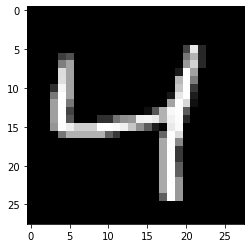

In [7]:
image, label = dataset[2]
plt.imshow(image, cmap='gray')
print('Label:', label)

Label: 7


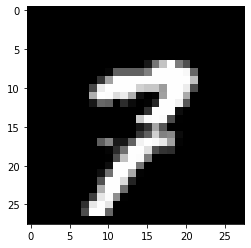

In [8]:
image, label = dataset[1499]
plt.imshow(image, cmap='gray')
print('Label:', label)

Observamos que las imagenes que tenemos son relativamente pequeñas y por tanto el reconocimento del dígito puede llegar a ser dificil, incluso para un ojo humano. No obstante, este dataset no deja de ser muy útil. 

Llegado este puntom el principal problema es que Pytorcho no sabe como trabajar con imagenes. De forma similar a otras librerías DL, será necesario transformar las imágenes a tensores. Podemos realizar esto directamente cuando creamos el dataset.

In [10]:
import torchvision.transforms as transforms

PyTorch datasets nos permite especificar una o más transformaciones que se aplican a las imagenes directamente cuando son cargadas. El módulo `torchvision.transforms` contiene esas funciones predefinidas. Vamos a emplear la transformación `ToTensor` para convertir las imágenes a tensores PyTorch.

In [11]:
# MNIST dataset (imagenes and labels)
dataset = MNIST(root='data/', 
                train=True,
                transform=transforms.ToTensor())

In [12]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


Ahora la imagen ya es un tensor de dimensiones 1x28x28. La primera dimensión indica los canales de color. La segunda y la tercera implican la altura y anchura de la imagen, respectivamente. Como las imñagenes son en escala de grises, solo hay un canal de color. Otros conjuntos de datos con imágenes en colo tendrían 3 canales: rojo, verde y azul (RGB).

Veamos algunos valores del interior del tensor:

In [13]:
print(img_tensor[0,10:15,10:15])
print(torch.max(img_tensor), torch.min(img_tensor))

tensor([[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
        [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
        [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
        [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
        [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]])
tensor(1.) tensor(0.)


La segunda línea de código nos muestra el rango de valores, que va de 0 a 1. O representa el negro, 1 el blanco,  y los valores intermedios representan los diferentes tonos de grises. 

Veamos gráficamente el tensor como imagen empleando `plt.imshow`.

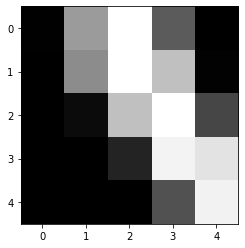

In [14]:
plt.imshow(img_tensor[0,10:15,10:15], cmap='gray');

## Conjuntos de entrenamiento, test y validación

Como ya sabemos, cuando construimos modelos reales de aprendizaje máquina, es habitual dividir el conjunto de datos en tres partes: 

1. **Training set** - empleado para entrenar el modelo. Es con el que calculamos el error y usamos para ajustar los pesos empleando el algoritmo de optimización elegido (p.e. descenso de gradiente).
2. **Validation set** - se emplea para evaluar el modelo durante el entrenamiento, ajustar los hiperparámetros (como learning rate, etc.) y de esa forma escoger la mejor versión obtenida. 
3. **Test set** - empleado para comparar diferentes modelos entrenados y para aproximar el modelo a su eficacia final con nuevos datos. .

En el conjunto MNIST tenemos 60.000 imágenes para entrenamiento y 10.000 para test. El conjunto de test está específicamente preparado, de forma que diferentes investigadores puedan comprobar y reportar sus resultados contra la misma colección de imagenes.  

Dado que no hay un conjunto predefinido de validación, lo vamos a obtener nosotros manualmente dividiendo el conjunto de entrenamiento. Vamos a separar 10.000 imágenes aleatoriamente para validación. Para ello emplearemos el método `random_spilt` de PyTorch.

In [15]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

Es fundamental que la división de los conjuntos sea **aleatoria**. A menudo, el conjunto de entrenamiento puede estar ordenado de alguna forma. Si nos limitaramos a tomar el ultimo 20% de las imágenes, podriamos estar dejando fuera tanto de entrenamiento como de validación algunas etiquetas. Esto nos llevaría a un modelo defectuoso, que estaría mal entrenado y no sería nada útil.

Llegado este punto ya podemos crear data loaders que nos van ayudar a cargar los datos en lotes. En este caso emplearemos lotes de 128 elementos. 




In [16]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

Recordemos que hemos de poner `shuffle=True` para el dataLoader de entrenamiento de forma que aseguremos que los lotes que se generan en cada ciclo (epoch) son diferentes. Esta alatorización ayuda a entrenar más rápido y a generalizar mejor. Por otro lado, dado que el conjunto de validación únicamente es emmpleado para evaluar el modelo, no es necesario barajar las imágenes. 

## Modelo

A continuación vamos a preparar nuestro modelo, teniendo en cuenta las siguientes consideraciones: 

* Un modelo de  **regresión logística** es practicamente idéntico a un modlo de regresión lineal. Contiene matrices de pesos y biases y su salida se obtiene realizando las mismas operaciones básicas (`pred = x @ w.t() + b`). 

* De igual forma que con la regresion lineal, podemos emplear la clase base `nn.Linear` para crear el modelo en lugar de crear e inicializar manualmente las matrices.

* Dado que `nn.Linear` espera que cada muestra de entrenamiento sea un vector, ahora cada tensor imagen de `1x28x28` tiene que ser "extendido" (_flattened_) a un vector de tamaño 784 `(28*28)` antes de ser pasado al modelo. 

* Finalmente, en este caso la salida para la imagen ya no es un solo valor, sino un vector de tamaño 10, en el que cada elemento significa la probabilidad de que el elemento de entrada sea esa etiqueta en particular (i.e., 0 al 9). La etiqueta predicha será simplemente aquella con el valor de probabilidad más alto. 

In [17]:
import torch.nn as nn

input_size = 28*28
num_classes = 10

# Modelo de regresión logística
model = nn.Linear(input_size, num_classes)

Este modelo es mucho más grande que el modelo anterior en términos del número de parametros que hay que ajustar (ahora tenemos 10 salidas en lugar de una). 

Veamos los pesos y biases: 

In [18]:
print(model.weight.shape)
model.weight

torch.Size([10, 784])


Parameter containing:
tensor([[-0.0335, -0.0251, -0.0098,  ...,  0.0028,  0.0233, -0.0193],
        [-0.0096, -0.0291, -0.0228,  ...,  0.0172, -0.0143,  0.0071],
        [-0.0322, -0.0187, -0.0300,  ...,  0.0322, -0.0003,  0.0090],
        ...,
        [ 0.0168,  0.0041,  0.0072,  ...,  0.0007, -0.0032, -0.0339],
        [-0.0127, -0.0162,  0.0133,  ..., -0.0122,  0.0340, -0.0210],
        [-0.0322, -0.0289, -0.0016,  ...,  0.0348,  0.0020,  0.0081]],
       requires_grad=True)

In [19]:
print(model.bias.shape)
model.bias

torch.Size([10])


Parameter containing:
tensor([-0.0261, -0.0307, -0.0295, -0.0255,  0.0080, -0.0215,  0.0088, -0.0171,
        -0.0161,  0.0253], requires_grad=True)

Aunque ahora tenemos un total de 7850 parametros, conceptualmente no hay nada muy diferente. Vamos a generar algunos resultados con el modelo que hemos definido. 
Vamos a emplear el primer lote de 128 imágenes del dataset y lo pasamos a nuestro modelo.

In [20]:
for images, labels in train_loader:
    print(labels)
    print(images.shape)
    outputs = model(images)
    print(outputs)
    break

tensor([7, 0, 1, 1, 1, 6, 1, 5, 0, 8, 1, 7, 5, 3, 2, 7, 8, 7, 8, 9, 1, 8, 6, 2,
        1, 1, 9, 7, 8, 3, 4, 2, 0, 3, 6, 3, 0, 1, 7, 9, 8, 1, 3, 2, 3, 8, 5, 7,
        0, 9, 4, 7, 7, 1, 0, 6, 0, 9, 5, 7, 1, 8, 1, 9, 8, 0, 1, 6, 7, 2, 1, 6,
        1, 6, 4, 3, 6, 5, 5, 8, 4, 7, 9, 0, 8, 8, 3, 3, 3, 8, 5, 2, 2, 7, 3, 7,
        1, 1, 7, 1, 7, 2, 4, 3, 2, 4, 1, 9, 2, 1, 5, 5, 5, 6, 4, 3, 2, 7, 6, 9,
        9, 7, 8, 7, 9, 5, 6, 4])
torch.Size([128, 1, 28, 28])


RuntimeError: ignored

In [21]:
images.shape

torch.Size([128, 1, 28, 28])

In [22]:
images.reshape(128, 784).shape

torch.Size([128, 784])

El códio anterior nos ha producido erro porque los datos de entrada no están en la forma correcta. Nuestras imágenes son 1x28x28, pero nosotros las necesitamos como vectores de tamaño 784, i.e. necesitamos "extenderlas". Para ello emplearemos el método de tensores `.reshape`, que nos va a permitir eficientemente generar una vista de cada imagen como un vector, sin realmente crear una copia de los datos.  

Para incluir esta funcionalidad en nuestro modelo, necesitamos definir un modelo personalizado extendiendo la clase `nn.Module` de PyTorch. 


In [23]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
model = MnistModel()

En el interior del constructor `__init__`, lo que hacemos ens instanciar los pesos y biases empleando `nn.Linear`, de igual forma que lo que hemos visto anteriormente. A continuación preparamos un nuevo método `forward`, el cual toma un lote de entradas cuando es invocado, lo "extiende" al formato de tensor de entrada correcto, y lo pasa a la función `self.linear`.

`xb.reshape(-1, 28*28)` indica a PyTorch que quremos una *vista* del tensor `xb` en dos dimensiones. La longitud de la segunda dimensión la hemos especificado nosotros (28x28=784). Un argumento de `.reshape` puede ser puesto a `-1` (en nuestro caso, la primera dimensión) para hacer que PyTorch calcule automáticamente el valor necesario, basado en la forma especificada.

Nótese que el modelo ya no tiene los atributos `.weight` y `.bias` (ahora están dentro del attributo `.linear`), pero sí que tiene un método `.parameters` que retorna na lista conteniendo los pesos y biases.

In [24]:
model.linear

Linear(in_features=784, out_features=10, bias=True)

In [25]:
model.linear.bias



Parameter containing:
tensor([ 0.0124, -0.0287,  0.0037, -0.0268, -0.0101,  0.0248, -0.0048, -0.0208,
         0.0282,  0.0097], requires_grad=True)

In [26]:
print(model.linear.weight.shape, model.linear.bias.shape)
list(model.parameters())

torch.Size([10, 784]) torch.Size([10])


[Parameter containing:
 tensor([[-0.0037, -0.0310, -0.0225,  ..., -0.0188,  0.0167,  0.0254],
         [ 0.0128, -0.0073,  0.0003,  ...,  0.0234,  0.0283, -0.0092],
         [ 0.0193, -0.0011,  0.0292,  ..., -0.0308, -0.0280,  0.0133],
         ...,
         [ 0.0188, -0.0047,  0.0059,  ..., -0.0146,  0.0322, -0.0246],
         [ 0.0220,  0.0325, -0.0002,  ..., -0.0228,  0.0142, -0.0203],
         [-0.0356, -0.0122,  0.0173,  ..., -0.0036,  0.0233,  0.0008]],
        requires_grad=True), Parameter containing:
 tensor([ 0.0124, -0.0287,  0.0037, -0.0268, -0.0101,  0.0248, -0.0048, -0.0208,
          0.0282,  0.0097], requires_grad=True)]

Ahora podemos usar el modelo que hemos definido. Veamos si funciona correctamente: 

In [27]:
for images, labels in train_loader:
    print(images.shape)
    outputs = model(images)
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

torch.Size([128, 1, 28, 28])
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[ 5.2753e-01, -2.1475e-01, -1.0958e-01,  1.4950e-04,  1.7668e-01,
         -6.3830e-01, -1.7347e-01,  1.6723e-01, -2.6118e-01,  2.9498e-02],
        [-2.0242e-02, -1.4736e-01, -1.3137e-01,  1.3729e-02,  1.6410e-01,
         -2.1138e-01,  4.1514e-02,  1.6834e-03, -2.1475e-01,  2.1246e-01]])


Para cada una de las 128 imagenes, ahora tenemos 10 salidas, una por cada clase. Como se ha indicado anteriormente, tomaremos esos valores de salida como posibilidades. Para ello, los valores de salida deben estar entre el rango 0 y 1, lo cual no es el caso. 

Para realizar la transformación de los valores obtenidos a probabilidades, emplearemos la función sofmax, que tiene la siguiente fórmula: 

![softmax](https://i.imgur.com/EAh9jLN.png)

Primero reemplazamos cada elemento `yi` de una fila de salida en `e^yi`, haciendo todos los elementos positivos. 

![](https://www.montereyinstitute.org/courses/DevelopmentalMath/COURSE_TEXT2_RESOURCE/U18_L1_T1_text_final_6_files/image001.png)

A continuación dividimos cada uno entre la suma de todos, para asegurar que no superamos el valor 1. El vector vestor resultante ya puede ser interpretado como probabilidades.

A pesar de que implementar directamente la función sofmax no es dificil, Pytorch ya cuenta con una implementación propia que además funciona muy bien con tensores multidimensionales (p.e. una lista de filas de salida en nuestro caso)


In [28]:
import torch.nn.functional as F

La función softmax está incluidoa en el paquete `torch.nn.functional` y requiere que le especifiquemos la dimensión a lo largo de la cual debe ser aplicada.

In [29]:
outputs[:2]

tensor([[ 5.2753e-01, -2.1475e-01, -1.0958e-01,  1.4950e-04,  1.7668e-01,
         -6.3830e-01, -1.7347e-01,  1.6723e-01, -2.6118e-01,  2.9498e-02],
        [-2.0242e-02, -1.4736e-01, -1.3137e-01,  1.3729e-02,  1.6410e-01,
         -2.1138e-01,  4.1514e-02,  1.6834e-03, -2.1475e-01,  2.1246e-01]],
       grad_fn=<SliceBackward>)

In [30]:
# Aplicamos softmax para cada fila de salida
probs = F.softmax(outputs, dim=1)

# Miramos las probabilidades de unas muestras
print("Sample probabilities:\n", probs[:2].data)

# Comprobamos la suma de probabilidades de una fila:
print("Sum: ", torch.sum(probs[0]).item())

Sample probabilities:
 tensor([[0.1705, 0.0811, 0.0901, 0.1006, 0.1200, 0.0531, 0.0846, 0.1189, 0.0775,
         0.1036],
        [0.0999, 0.0880, 0.0894, 0.1034, 0.1201, 0.0825, 0.1063, 0.1021, 0.0822,
         0.1261]])
Sum:  1.0


Finalmente elegiremos la etiqueta de salida simplemente seleccionando el índice de la que mayores probabilidades ha obtenido en cada fila (vector) de salida. Para ello podemos usar `torch.max`, que retorna para cada fila, el mayor elemento y su correspondiente índice.

In [31]:
max_probs, preds = torch.max(probs, dim=1)
print(preds)
print(max_probs)

tensor([0, 9, 9, 4, 0, 4, 2, 0, 4, 4, 1, 0, 3, 8, 4, 0, 0, 8, 0, 0, 7, 7, 0, 0,
        4, 0, 7, 9, 0, 4, 4, 5, 0, 0, 7, 7, 4, 4, 0, 8, 0, 2, 7, 6, 0, 0, 4, 7,
        7, 0, 7, 0, 0, 3, 2, 7, 4, 4, 7, 7, 0, 4, 4, 8, 7, 0, 9, 6, 0, 0, 4, 6,
        9, 0, 9, 8, 4, 3, 4, 0, 4, 0, 8, 0, 4, 4, 7, 7, 4, 9, 7, 7, 4, 1, 7, 8,
        1, 4, 7, 0, 0, 3, 0, 7, 8, 8, 3, 7, 7, 0, 4, 7, 4, 2, 0, 6, 3, 9, 7, 7,
        8, 0, 7, 4, 2, 4, 9, 0])
tensor([0.1705, 0.1261, 0.1110, 0.1312, 0.1374, 0.1124, 0.1364, 0.1405, 0.1355,
        0.1256, 0.1358, 0.1063, 0.1418, 0.1210, 0.1480, 0.1203, 0.1309, 0.1150,
        0.1228, 0.1539, 0.1401, 0.1422, 0.1382, 0.1518, 0.1147, 0.1507, 0.1202,
        0.1208, 0.1271, 0.1247, 0.1237, 0.1211, 0.1426, 0.1537, 0.1379, 0.1196,
        0.1376, 0.1269, 0.1187, 0.1263, 0.1237, 0.1117, 0.1216, 0.1135, 0.1353,
        0.1247, 0.1187, 0.1348, 0.1223, 0.1334, 0.1148, 0.1264, 0.1264, 0.1510,
        0.1336, 0.1199, 0.1249, 0.1303, 0.1143, 0.1248, 0.1361, 0.1471, 0.1290,
       

Los números mostrados arriba son las etiquetas predichas para el primer lote de entrenamiento. Vamos a compararlas con las reales. 

In [32]:
labels

tensor([3, 4, 7, 5, 3, 1, 9, 3, 5, 0, 0, 7, 7, 1, 5, 0, 2, 1, 4, 6, 9, 0, 8, 3,
        1, 6, 6, 9, 2, 1, 1, 4, 6, 6, 0, 9, 1, 8, 8, 1, 3, 5, 0, 7, 9, 1, 1, 0,
        0, 8, 5, 0, 7, 2, 6, 7, 0, 3, 4, 5, 3, 3, 3, 7, 5, 3, 4, 7, 8, 0, 3, 1,
        9, 2, 9, 2, 1, 8, 1, 9, 5, 2, 1, 2, 8, 6, 5, 9, 8, 9, 3, 6, 1, 0, 3, 8,
        0, 7, 5, 2, 9, 2, 2, 8, 8, 3, 8, 5, 4, 9, 1, 2, 8, 7, 9, 4, 2, 4, 9, 6,
        1, 8, 6, 5, 9, 7, 9, 5])

La mayoría de las etiquetas de predicción son diferentes de las reales. Esto es porque hemos empezado con unos valores de pesos y biases elegidos al azar. Evidentemente, necesitamos entrenar el modelo para ajustar los pesos y realizar mejores predicciones.

## Métrica de evaluación y función de error

De igual forma que en la regresión linealm necesitamos una forma para evaluar como de bien está haciendolo nuestro modelo. Una forma básica y muy natural consiste en obtener el porcentaje de etiquetas que son correctamente predichas, i.e. la **precision** (**accuracy**)  de las predicciones.

In [33]:
outputs[:2]

tensor([[ 5.2753e-01, -2.1475e-01, -1.0958e-01,  1.4950e-04,  1.7668e-01,
         -6.3830e-01, -1.7347e-01,  1.6723e-01, -2.6118e-01,  2.9498e-02],
        [-2.0242e-02, -1.4736e-01, -1.3137e-01,  1.3729e-02,  1.6410e-01,
         -2.1138e-01,  4.1514e-02,  1.6834e-03, -2.1475e-01,  2.1246e-01]],
       grad_fn=<SliceBackward>)

In [34]:
torch.sum(preds == labels)

tensor(11)

In [35]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

El  operador `==` realiza una comparación elemento por elemento de los dos tensores que tienen la misma forma y retorna un tensor de resultados de la misma forma, conteniendo `True` para elementos iguales y `False` para los diferentes. Pasando el resultado a `torch.sum` nos retorna el número total de etiquetas que se han predicho correctamente. Finalmente dividimos entre el numero total de etiquetas evaluadas para obtener la precisión. 

Nótese que en este caso no es necesario aplicar la función softmax al vector de resultados. Esto es así porque `e^x` es una función incremental, i.e., si `y1 > y2`, entonces `e^y1 > e^y2`. Lo mismo se cumple despues de promediar los valores para obtener el softmax. Por tanto podemos saltarnos esa transformación tomando directamente el valor máximo del vector de salida.

Calculamos la precision del modelo para el primer lote de datos (sin entrenar)
Let's calculate the accuracy of the current model on the first batch of data. 

In [36]:
accuracy(outputs, labels)

tensor(0.0859)

In [37]:
probs

tensor([[0.1705, 0.0811, 0.0901,  ..., 0.1189, 0.0775, 0.1036],
        [0.0999, 0.0880, 0.0894,  ..., 0.1021, 0.0822, 0.1261],
        [0.1020, 0.0935, 0.1088,  ..., 0.0965, 0.0804, 0.1110],
        ...,
        [0.1156, 0.0825, 0.0944,  ..., 0.0927, 0.0894, 0.1060],
        [0.1103, 0.0899, 0.1043,  ..., 0.1179, 0.0837, 0.1218],
        [0.1259, 0.1005, 0.0886,  ..., 0.0950, 0.0870, 0.1094]],
       grad_fn=<SoftmaxBackward>)

La precisión es una buena forma de evaluar el modelo para nosotros (como humanos). Sin embargo, no la podemos emplear para optimizar el modelo empleando la técnica de descenso de gradiente por las siguientes razones: 

1. No es una función diferenciable. Tanto `torch.max` como `==` son operaciones no-continuas y no-diferenciables. Por tanto no podemos calcular gradientes con repecto a los pesos y los biases, que nos puedan servir para actualizar los valores en la dirección correcta.

2. No tiene en cuenta las probabilidades obtenidas por el modelo, lo que hace que no podamos proveer de suficiente realimentación al modelo para mejoras incrementales. 

Por esas razones, la precision es utilizada habitualemente como **métrica de evaluacion** pero no como función de pérdida (tambien llamada función de coste). La función de pérdida comúnmente empleada en problemas de clasificación es la función de **entropía cruzada**  (_cross-entropy_), que tiene la siguiente fórmula: 

![cross-entropy](https://i.imgur.com/VDRDl1D.png)

Aunque pueda parecer un poco complicada, en realidad es bastante simple:

* Para cada vector de salida, tomamos el valor de probabilidad obtenido para la etiqueta correcta. E.g., si las probailidades obtenidas para una imagen son `[0.1, 0.3, 0.2, ...]` y la etiqueta correcta es `1`, tomaremos el valor `0.3` e inoramos el resto

* A continuación obtenemos el [logaritmo](https://en.wikipedia.org/wiki/Logarithm) del valor de probailidad obtenida.  Si la probabilidad es alta, i.e. cercana a 1, entonces el valor obtenido será cercano a 0. Si la probabilidad es baja (cercana a 0) entonces el valor obtenido será un valor negativo alto. Dicho valor lo multiplicaremos por -1 para convertirlo en positivo. Esto resulta en que cuando la predicción es baja obtenemos un valor alto que será tomado como la pérdida o error. Cuando la predicción es alta, el error estará cercano a 0. 

![](https://www.intmath.com/blog/wp-content/images/2019/05/log10.png)

* Finalmente para aprovechar la información de todas las muestras empleadas, tomaremos el promedio de entropía cruzada de todas las filas de salida y tenemos una medida de la pérdida para todo un lote de datos. 

A diferencia de la precisión. la entropía cruzada es continua y diferenciable. También provee una información de feedback muy útil para esas mejoras incrementales necesarias (mayores probabilidades se traducen en menor pérdida o error). Esas características hacen que esta función sea una buena elección como función de coste para entrenar el modelo. 

Como era de esperar Pytorch tiene una implementación propia eficiente y preparada para tensores como parte del paquete `torch.nn.functional`. Más aún, tiene implementado internamente la función softmax, por lo que podemos pasarle directamente la salida del modelo sin tener que convertirlo en probavilidades. 

In [38]:
outputs

tensor([[ 0.5275, -0.2148, -0.1096,  ...,  0.1672, -0.2612,  0.0295],
        [-0.0202, -0.1474, -0.1314,  ...,  0.0017, -0.2148,  0.2125],
        [ 0.0879,  0.0014,  0.1528,  ...,  0.0329, -0.1500,  0.1726],
        ...,
        [ 0.1756, -0.1621, -0.0275,  ..., -0.0452, -0.0816,  0.0883],
        [ 0.1846, -0.0201,  0.1285,  ...,  0.2517, -0.0906,  0.2838],
        [ 0.2162, -0.0090, -0.1344,  ..., -0.0655, -0.1528,  0.0757]],
       grad_fn=<AddmmBackward>)

In [39]:
loss_fn = F.cross_entropy

In [40]:
# Pérdida para el lote actual de datos
loss = loss_fn(outputs, labels)
print(loss)

tensor(2.3332, grad_fn=<NllLossBackward>)


Ahora sabemos que la entropía cruzada es el negativo del logaritmo de la probabilidad predicha para la etiqueta correcta, promediado sobre todas las muestras. Por tanto, una forma en la que podemos interpretar el número resultante obtenido e.g. `2.23` es que `e^-2.23` que es en torno a `0.1` como la probabilidad promedio de acierto de etiqueta correcta. En definitica *cuanto menor pérdida o error, mejor es el modelo*

## Entrenamiento del modelo

Ahora que ya hemos definido la carga de datos, función de coste y optimizador, estamos listos para entrenar el modelo. El proceso es idéntico al de la regresión lineal, con el añadido de que ahora tenemos una fase de validación para evaluar el modeloo en cada ciclo/epoch. 

Veamos como queda esto en pseudocódigo:

```
for epoch in range(num_epochs):
    # Fase de entrenamiento
    for batch in train_loader:
        # Genera predicciones
        # Calcula el error/pérdida
        # Calcula los gradientes c.r.a. los pesos y biases
        # Actualiza los pesos
        # Reseteamos los gradientes a cero 
    # Fase de validación
    for batch in val_loader:
        # Genera predictiones
        # Calcula perdida
        # Calcula metricas (accuracy etc.)
    # Calcula promediado de loss & metricas
    
    # Log epoch, loss & metrics para inspecion
```

Algunas partes del bucle de entrenamiento son específicas del problema que estamos enfrentando (e.g. loss function, metricas etc.) mientras otras son genéricas y pueden ser aplicadas a cualquier problema de aprendizaje máquina. 

Lo que vamos a hacer es incluir las partes independientes del problema en una función que llamaremos `fit` y que emplearemos para entrenar el modelo. Las partes más específicas las implementaremos añaiendo métodos a la clase base  `nn.Module` que definiremos.



In [41]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # Aquí guardaremos resultados por epochs
    
    for epoch in range(epochs):
        
        # Entrnamiento 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validación
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

En esta función `fit`  vamos a grabar la pérdida de validación y la métrica para cada epoch. Nos devuelve un histórico del entrenamiento realizado, lo cual será útil para visualizar y deputar. 

Configuraciones como el tamaño de lote, tasa de aprendizaje, etc. (llamados hiperparámetros) son críticos para la obtención de buenos modelos y tiempos de entrenamiento razonables. Son un área activa de investigación por sí solos. Resulta interesante (y normalmente necesario) ir probando con ellospara ver como afecta al proceso y resultados de entrenmiento.

Definimos ahora una función `evaluate` que emplearemos en la fase de validación de la function `fit`.

In [42]:
l1 = [1, 2, 3, 4, 5]

In [43]:
l2 = [x*2 for x in l1]
l2

[2, 4, 6, 8, 10]

In [44]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

Finalmente vamos a redefinir la clase `MnistModel` para incluir una serie de métodos adicionales `training_step`, `validation_step`, `validation_epoch_end`, y `epoch_end` que aprovecharemos en las funciones `fit` y `evaluate`.

In [45]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Genera predicciones
        loss = F.cross_entropy(out, labels) # Calcula loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Genera predicciones
        loss = F.cross_entropy(out, labels)   # Calcula loss
        acc = accuracy(out, labels)           # Calcula accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combina losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combina accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()

Antes de entrenar nuestro nuevo modelo, vamos a ver que resultados obtiene con los pesos y biases inicializados aleatoriamente en la fase inicial.

In [46]:
result0 = evaluate(model, val_loader)
result0

{'val_acc': 0.11837420612573624, 'val_loss': 2.2922189235687256}

La precisión inicial es en torno al 10%, que es lo que uno puede esperar de un modelo aleatorio teniendo en cuenta que tenemos 10 valores posibles de salida ( es decir, una posibilidad entre 10 de acertar al escoger aleatoriamente).

Vamos a entrenar ahora el modelo. Configuramos 5 epochs inicialmente y observamos los resultados

In [47]:
history1 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9317, val_acc: 0.6368
Epoch [1], val_loss: 1.6676, val_acc: 0.7388
Epoch [2], val_loss: 1.4696, val_acc: 0.7703
Epoch [3], val_loss: 1.3198, val_acc: 0.7872
Epoch [4], val_loss: 1.2044, val_acc: 0.7993


Ahora tenemos un gran resultado! Simplemente hemos entrenado 5 ciclos y ya estamos en torno al 80% en el validation set. Veamos si epodemos mejorar más entrenando algunos ciclos más. Prueba a cambiar el número de ciclos o learning rate en las celdas siguientes y observa los resultados.

In [48]:
history2 = fit(10, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.1139, val_acc: 0.8071
Epoch [1], val_loss: 1.0412, val_acc: 0.8137
Epoch [2], val_loss: 0.9817, val_acc: 0.8196
Epoch [3], val_loss: 0.9322, val_acc: 0.8236
Epoch [4], val_loss: 0.8904, val_acc: 0.8276
Epoch [5], val_loss: 0.8547, val_acc: 0.8316
Epoch [6], val_loss: 0.8237, val_acc: 0.8340
Epoch [7], val_loss: 0.7966, val_acc: 0.8372
Epoch [8], val_loss: 0.7727, val_acc: 0.8396
Epoch [9], val_loss: 0.7514, val_acc: 0.8416


In [49]:
history3 = fit(10, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.7323, val_acc: 0.8432
Epoch [1], val_loss: 0.7151, val_acc: 0.8451
Epoch [2], val_loss: 0.6995, val_acc: 0.8469
Epoch [3], val_loss: 0.6853, val_acc: 0.8484
Epoch [4], val_loss: 0.6722, val_acc: 0.8502
Epoch [5], val_loss: 0.6602, val_acc: 0.8511
Epoch [6], val_loss: 0.6491, val_acc: 0.8530
Epoch [7], val_loss: 0.6388, val_acc: 0.8539
Epoch [8], val_loss: 0.6293, val_acc: 0.8550
Epoch [9], val_loss: 0.6203, val_acc: 0.8560


In [50]:
history4 = fit(15, 0.0001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.6195, val_acc: 0.8563
Epoch [1], val_loss: 0.6186, val_acc: 0.8565
Epoch [2], val_loss: 0.6178, val_acc: 0.8566
Epoch [3], val_loss: 0.6169, val_acc: 0.8566
Epoch [4], val_loss: 0.6161, val_acc: 0.8568
Epoch [5], val_loss: 0.6153, val_acc: 0.8568
Epoch [6], val_loss: 0.6144, val_acc: 0.8569
Epoch [7], val_loss: 0.6136, val_acc: 0.8572
Epoch [8], val_loss: 0.6128, val_acc: 0.8572
Epoch [9], val_loss: 0.6120, val_acc: 0.8572
Epoch [10], val_loss: 0.6112, val_acc: 0.8573
Epoch [11], val_loss: 0.6104, val_acc: 0.8575
Epoch [12], val_loss: 0.6096, val_acc: 0.8575
Epoch [13], val_loss: 0.6088, val_acc: 0.8575
Epoch [14], val_loss: 0.6080, val_acc: 0.8576


Aunque la precisión va mejorando cuando continuamos el entrenamiento, las mejoras son cada vez más pequeñas. 

Veamos esto en un gráfico:


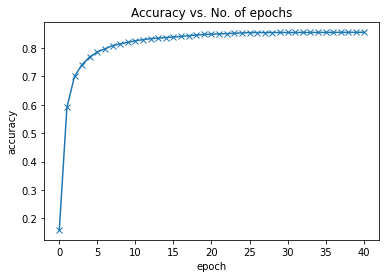

In [ ]:
history = [result0] + history1 + history2 + history3 + history4
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

A la vista de los resultados obtenidos y del gráfico, se aprecia fácilmente que probablemente nuestro modelo no pueda ir mucho más allá dde un 905 de precisión, incluso después de entrenar bastantes ciclos. Una posible explicación para esto es que tengamos una tasa de aprendizaje (_learning rate_) alta y sea muy dificil acceder a esas pequeñas mejoras debido al tamaño del  "paso" (recordemos el gráfico de la curva del error y el gradiente). Los valores obtenidos pueden estar dando vueltas alrededor del punto óptimo con el mínimo error. Se debe probar diferentes tasas de aprendizaje durante más ciclos de entrenamiento para observar si eso mejora. 

Sin embargo, otra razón, probablemente más importante es que **el modelo no es lo bastante potente**. Si recordamos la hipótesis inicial planteada al plantear el modelo, hemos asumido que la salida (en este caso las probabilidades de cada clase de salida) es una **función lineal** de las entradas (intensidades de los píxels), ponderadas por unos pesos y on un factor de ajuste al que llamamos bias. Pero eso es una presunción muy débil, pues no tiene porqué existir una relacion lineal entre la intensidad de los píxels en una imagen y el número que representan. Es por ello que aunque funciona razonablemente bien con un pequeño conjunto como MNIST (se ha obtenido en torno al 85%), necesitaremos modelos más sofísticados que sean capaces de captar también relaciones no lineales entre las variables de entrada y sus etiquetas, de forma que puedan ser aplicados en tareas más complejas como clasificación avanzada, reconocimiento de objetos, personas, etc.


## Probando con imágenes individuales

Una vez que hemos explorado los resultados y la precisión del modelo entrenado, también es necesario ver que resultados produce sobre imágenes nuevas. 
Vamos a probar el modelo con algunas del conjunto de test de 10000 imágenes que como sabemos, no ha intervenido en ningun momento en el entrenamiento. Empezaremos por generar el test dataset empleando el metodo transform de `ToTensor`.

In [51]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=transforms.ToTensor())

Revisamos algun eejemplo del conjunto test. 

Shape: torch.Size([1, 28, 28])
Label: 0


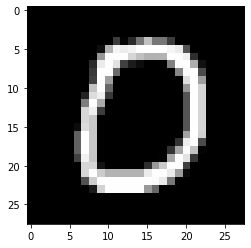

In [52]:
img, label = test_dataset[10]
plt.imshow(img[0], cmap='gray')
print('Shape:', img.shape)
print('Label:', label)

Podemos ahora definir una función auxiliar `predict_image`, que devolverá la etiqueta obtenida para una sola imagen, proporcionada en un tensor individual. 

In [53]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

`img.unsqueeze` lo que hace es añadir una dimensión adicional al principio del tensor de la imagen 1x28x28, convirtiendolo en un tensor de 1x1x28x28, que el modelo interpretarla como un lote conteniendo una sola imagen

Probamos con varias imágenes: 

Label: 7 , Predicted: 7


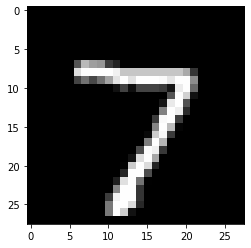

In [54]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 0 , Predicted: 0


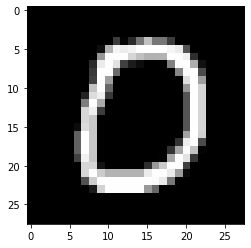

In [55]:
img, label = test_dataset[10]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 9 , Predicted: 9


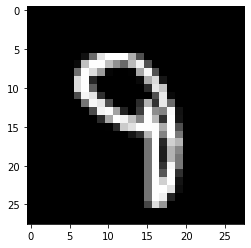

In [56]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 8


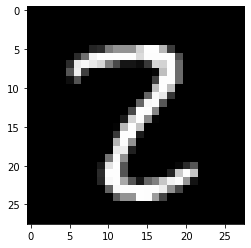

In [57]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Identificando donde lo hace peor nuestro modelo nos puede orientar a mejorar el modelo bien recogiendo más datos de entrenamiento, ajaustando los hiperparámetros, incrementando/ o reduciendo la complejidad del modelo, etc.

Como paso final, vamos a obtener los valores de loss y accuracy del modelo sobre todo el conjunto de test. 

In [58]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model, test_loader)
result

{'val_acc': 0.8681640625, 'val_loss': 0.5735012292861938}

Lso resultados obtenidos con el conjunto de test nos pueden orientar sobre las  formas de afrontar una mejora. Si los resultados son muy distintos, es posible que el conjunto de test no esté correctamente muestreado y por tanto no tenga similar distribución a los empleados en el entrenamiento. También se pueden detectar situaciones de sobreajuste en el entrenamiento. En general, valores similares en entrenamiento y test indican que al menos metodológicamente el modelo está bien planteado, si bien puede necesitar mejoras en parámetros, arquitectura, etc. para aumentar sus resultados.

## Salvar y cargar el modelo

Una vez entrenado el modelo (lo cual puede haber requerido mucho tiempo) y obtenido unos resultados aceptables, es importante poder guardar los pesos y biases obtenidos, de forma que podamos recuperarlos y reutilizarlos cuando queramos, evitando así tener que reentrenar desde cero. 

Una forma de grabar el modelo será la siguiente:

In [59]:
torch.save(model.state_dict(), 'mnist-logistic.pth')

El método `.state_dict` retorna un `OrderedDict` conteniendo las matrices con los pesos y biases mapeados del modelo que hemos especificado. 

In [60]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0336, -0.0045,  0.0063,  ..., -0.0064,  0.0209, -0.0070],
                      [-0.0059, -0.0071,  0.0048,  ..., -0.0297, -0.0181, -0.0351],
                      [-0.0041, -0.0023,  0.0307,  ..., -0.0100, -0.0277,  0.0215],
                      ...,
                      [-0.0054, -0.0341,  0.0073,  ...,  0.0156,  0.0229, -0.0054],
                      [-0.0294, -0.0131, -0.0054,  ...,  0.0030, -0.0170,  0.0008],
                      [-0.0244,  0.0300,  0.0175,  ...,  0.0094, -0.0264,  0.0123]])),
             ('linear.bias',
              tensor([-0.0595,  0.1336, -0.0386, -0.0632,  0.0444,  0.0861,  0.0141,  0.0418,
                      -0.0832, -0.0042]))])

**NOTA IMPORTANTE**: si ejecutas el método `torch.sav`en Colab, el fichero generado se graba temporalmente en el directorio de datos del cuaderno. Será necesario descargarlo a un equipo local o trasladarlo a otra ubicación permanente o se perderá cuando finalicemos la sesión. 

Para cargar los parámetros del modelo, podemos instanciar un nuevo objeto de la clase inicial `MnistModel`, y a continuación emplear el método `.load_state_dict`.

In [61]:
model2 = MnistModel()

In [62]:
# inicalmente los parámetros son los que se han adjudicado aleatoriamente al instanciar el objeto
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0175, -0.0159, -0.0026,  ..., -0.0044,  0.0047,  0.0137],
                      [ 0.0074, -0.0178,  0.0313,  ...,  0.0169, -0.0295,  0.0166],
                      [ 0.0315,  0.0341, -0.0114,  ...,  0.0076,  0.0091, -0.0028],
                      ...,
                      [ 0.0026, -0.0143,  0.0301,  ...,  0.0340,  0.0273, -0.0256],
                      [-0.0123, -0.0114,  0.0341,  ..., -0.0149, -0.0232, -0.0185],
                      [ 0.0025,  0.0342, -0.0125,  ...,  0.0325,  0.0083,  0.0259]])),
             ('linear.bias',
              tensor([-0.0171, -0.0126,  0.0228, -0.0236,  0.0322, -0.0208, -0.0101, -0.0127,
                       0.0031,  0.0279]))])

In [63]:
evaluate(model2, test_loader)

{'val_acc': 0.13437500596046448, 'val_loss': 2.3092026710510254}

In [64]:
model2.load_state_dict(torch.load('mnist-logistic.pth'))
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0336, -0.0045,  0.0063,  ..., -0.0064,  0.0209, -0.0070],
                      [-0.0059, -0.0071,  0.0048,  ..., -0.0297, -0.0181, -0.0351],
                      [-0.0041, -0.0023,  0.0307,  ..., -0.0100, -0.0277,  0.0215],
                      ...,
                      [-0.0054, -0.0341,  0.0073,  ...,  0.0156,  0.0229, -0.0054],
                      [-0.0294, -0.0131, -0.0054,  ...,  0.0030, -0.0170,  0.0008],
                      [-0.0244,  0.0300,  0.0175,  ...,  0.0094, -0.0264,  0.0123]])),
             ('linear.bias',
              tensor([-0.0595,  0.1336, -0.0386, -0.0632,  0.0444,  0.0861,  0.0141,  0.0418,
                      -0.0832, -0.0042]))])

Podemos comprobar que los parámetros que tenemos son los que habiamos grabado, y comprobamos que obtenemos en los mismos resultados de loss y accuracy en el conjunto de test, igual que antes.

In [65]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model2, test_loader)
result

{'val_acc': 0.8681640625, 'val_loss': 0.5735012292861938}

Observamos que los valores obtenidos son exactamente los mismos que obtuvimos al realizar la evaluación con el modelo `model` varias celdas más arriba, lo cual indica que los pesos se han cargado correctamente y que nuestro `modelo2` lo está haciendo tan bien como el modelo original de donde proceden los valores de los parámetros. 

## Fin del Notebook

Referencias y modelos empleados para el Notebook: 

*   Documentación de [Pytorch](https://pytorch.org/docs/stable/index.html) 
*   [PyTorch Tutorial for Deep Learning Researchers](https://github.com/yunjey/pytorch-tutorial) by Yunjey Choi
*   [FastAI](https://www.fast.ai/) development notebooks by Jeremy Howard.
*   Documentación y cursos en [Pierian Data](https://www.pieriandata.com/)
*   Tutoriales y notebooks del curso "Deep Learning with Pytorch: Zero to GANs" de [Aakash N S](https://jovian.ai/aakashns)



